# Binary model using transfer Learning RestNet50 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras import Sequential
from keras import layers
from keras import optimizers
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.applications import ResNet50V2
from keras import models
from keras.layers import Dropout, Flatten, Dense 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

import tools.visualizations as vis
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

train_path = "data/split/train/"
test_path = "data/split/test/"
val_path = "data/split/val/"

In [4]:

train_generator_bi = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.3)
val_generator_bi = ImageDataGenerator(rescale=1./255)
test_generator_bi= ImageDataGenerator(rescale=1./255)

In [5]:
train_bi = train_generator_bi.flow_from_directory(train_path,
                                               batch_size=3514,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

Found 3514 images belonging to 2 classes.


In [6]:
val_bi = val_generator_bi.flow_from_directory(val_path,
                                               batch_size=1172,
                                               target_size=(220,220),
                                               color_mode="rgb",
                                               class_mode="binary",
                                               shuffle=True,
                                               seed=42)

Found 1172 images belonging to 2 classes.


In [7]:
test_bi = test_generator_bi.flow_from_directory(test_path,
                                          batch_size=1172,
                                          target_size=(220,220),
                                          color_mode="rgb",
                                          class_mode="binary")

Found 1170 images belonging to 2 classes.


In [8]:
print(train_bi.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [9]:
train_images_bi, train_labels_bi = next(train_bi )
test_images_bi, test_labels_bi = next(test_bi )
val_images_bi, val_labels_bi = next(val_bi )

In [12]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (220,220,3), include_top = False)

In [13]:
np.random.seed(123)
model_bi = Sequential()

model_bi.add(resnet50)    
model_bi.add(Flatten())
model_bi.add(Dense(units = 128, activation = "relu"))
model_bi.add(Dropout(0.5))

model_bi.add(Dense(units = 1, activation = "sigmoid"))

In [16]:
resnet50.trainable = False

# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model_bi.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model 
print(len(model_bi.trainable_weights))

resnet50v2 False
flatten True
dense True
dropout True
dense_1 True
4


In [17]:
model_bi.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["acc"])

In [18]:
history_bi = model_bi.fit(train_images_bi, train_labels_bi, 
   epochs=10,
   batch_size=32, 
   validation_data=(val_images_bi , val_labels_bi))

Epoch 1/10
110/110 [==============================] - 328s 3s/step - loss: 3.4254 - acc: 0.8154 - val_loss: 0.1707 - val_acc: 0.9369
Epoch 2/10
110/110 [==============================] - 328s 3s/step - loss: 0.2067 - acc: 0.9213 - val_loss: 0.1684 - val_acc: 0.9283
Epoch 3/10
110/110 [==============================] - 323s 3s/step - loss: 0.1625 - acc: 0.9451 - val_loss: 0.2303 - val_acc: 0.9130
Epoch 4/10
110/110 [==============================] - 520s 5s/step - loss: 0.1080 - acc: 0.9644 - val_loss: 0.1861 - val_acc: 0.9360
Epoch 5/10
110/110 [==============================] - 328s 3s/step - loss: 0.0924 - acc: 0.9617 - val_loss: 0.2888 - val_acc: 0.9215
Epoch 6/10
110/110 [==============================] - 325s 3s/step - loss: 0.0896 - acc: 0.9644 - val_loss: 0.2586 - val_acc: 0.9352
Epoch 7/10
110/110 [==============================] - 323s 3s/step - loss: 0.0759 - acc: 0.9719 - val_loss: 0.2884 - val_acc: 0.9215
Epoch 8/10
110/110 [==============================] - 323s 3s/step - 

### Evaluation 

In [19]:
model_bi.evaluate( 
    test_images_bi , test_labels_bi, batch_size=50, verbose=1)

24/24 [==============================] - 86s 4s/step - loss: 0.2334 - acc: 0.9487


[0.2334410548210144, 0.9487179517745972]

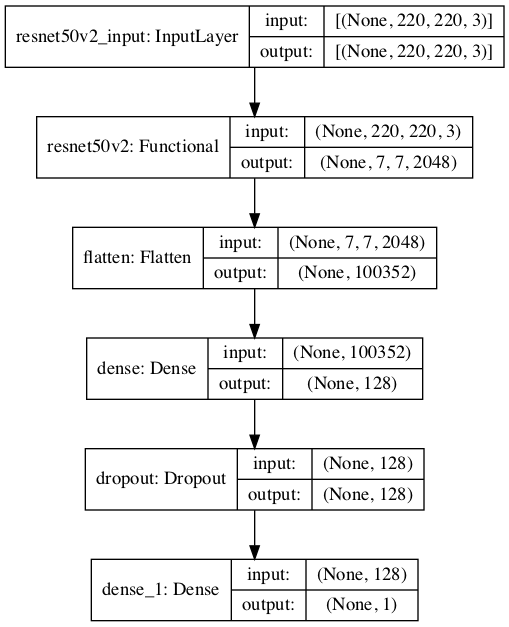

In [20]:
tf.keras.utils.plot_model(
    model_bi, to_file='images/model_bi_transfer_network.png', show_layer_names=True, show_shapes=True)

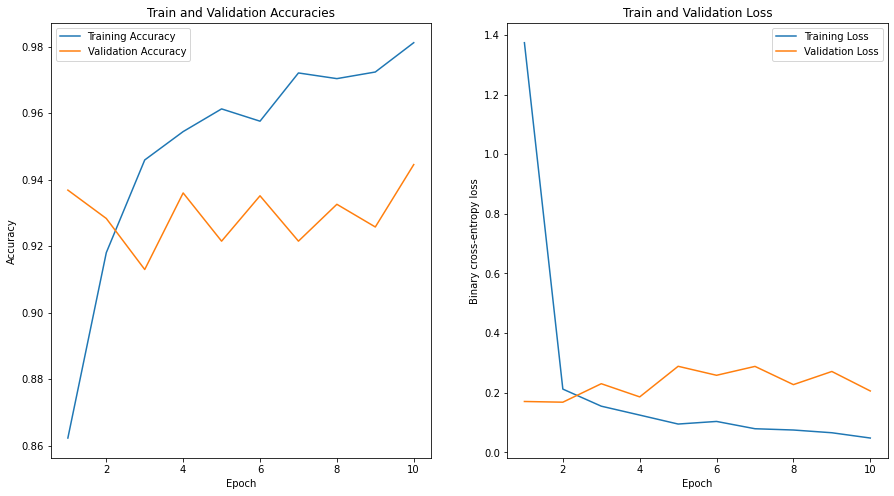

In [21]:
vis.plot_loss_accuracy(history_bi)
plt.savefig('images/transfer_model.png')
plt.show()

<AxesSubplot:>

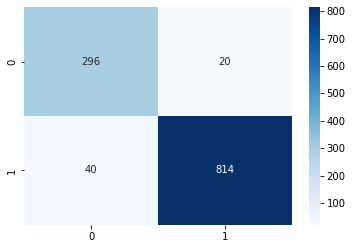

In [22]:
test_pred_labels = (model_bi.predict(test_images_bi) > 0.5).astype('int32')
test_cm = confusion_matrix(test_labels_bi, test_pred_labels)
sns.heatmap(data=test_cm,cmap='Blues',annot=True, fmt='d')


In [23]:
classification_metrics= classification_report(test_labels_bi,test_pred_labels, target_names=['NORMAL', 'PNEUMONIA'])
print(classification_metrics)

              precision    recall  f1-score   support

      NORMAL       0.88      0.94      0.91       316
   PNEUMONIA       0.98      0.95      0.96       854

    accuracy                           0.95      1170
   macro avg       0.93      0.94      0.94      1170
weighted avg       0.95      0.95      0.95      1170



In [27]:
#with open('models/model_transfer.pkl', 'wb') as f:
        #pickle.dump(model_bi.history.history, f)

In [28]:
#model_bi.save('models/model_transfer.h5')